In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
!pip install torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from statistics import mean

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14, 'axes.labelweight': 'bold', 'axes.grid': False})

In [2]:
# Use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


### 1: Load data

torch.Size([128, 3, 233, 311])

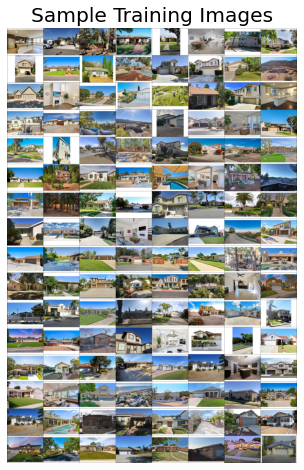

In [3]:
IMAGE_SIZE = (233, 311)
BATCH_SIZE = 128

data_dir = "../input/house-prices-and-images-socal/socal2"

# transformer setup
transformer = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset = datasets.ImageFolder(root=data_dir, transform=transformer)
data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=False
                                          )

sample_batch = next(iter(data_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

# to confirm the shape of input data
next(iter(data_loader))[0].shape

### 2: Create the Generator

In [13]:
class Generator(nn.Module):
    
    def __init__(self, LATENT_SIZE):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            
            # input dim: [-1, LATENT_SIZE, 1, 1]
            
            nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.3, inplace=True),
            
            # output dim: [-1, 512, 4, 4]

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.3, inplace=True),
            
            # output dim: [-1, 256, 8, 8]

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3, inplace=True),
            
            # output dim: [-1, 128, 16, 16]

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3, inplace=True),
            
            # output dim: [-1, 64, 32, 32]
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.3, inplace=True),
            
            # output dim: [-1, 32, 64, 64]
         
            nn.ConvTranspose2d(32, 3, kernel_size=(3, 4), stride=(4, 5), padding=(11, 4), bias=False),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 3, 233, 311]
            
            nn.Tanh()
            
            # output dim: [-1, 3, 233, 311]
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

### 3: Create the Discriminator

In [14]:
# discriminator = models.resnet18(pretrained=True)
# # list(discriminator.named_children())

In [15]:
# last_layer = nn.Sequential(
#         nn.Linear(512, 1),
# #         nn.Flatten(),
#         nn.Sigmoid()
#         )
# discriminator.fc = last_layer
# #summary(discriminator, (3, 233, 311))

In [16]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
        
            # input dim: [-1, 3, 233, 311]
            
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 64, 116, 155]

            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3, inplace=True),

            # output dim: [-1, 64, 58, 77]

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3, inplace=True),

            # output dim: [-1, 128, 29, 38]

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.3, inplace=True),

            # output dim: [-1, 256, 14, 19]

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.3, inplace=True),

            # output dim: [-1, 512, 7, 9]

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            
            # output dim: [-1, 1, 4, 6]

            nn.Flatten(),
            
            # output dim: [-1, 24]
            
            nn.Linear(24, 1),
            
            # output dim: [-1]

            nn.Sigmoid()
            
            # output dim: [-1]
        )

    def forward(self, input):
        output = self.main(input)
        return output

### 2.4: Initialize Weights

GANs can be quite sensitive to the initial weights assigned to each layer when we instantiate the model. Instantiate your generator and discriminator and then specify their initial weights as follows:
- `Conv2d()` layers: normal distribution with `mean=0.0` and `std=0.02`
- `ConvTranspose2d()` layers: normal distribution with `mean=0.0` and `std=0.02`
- `BatchNorm2d()` layers: normal distribution with `mean=1.0` and `std=0.02` for the weights, zeroes for the biases

In [17]:
# initiate generator (discriminator already initiated)
LATENT_SIZE = 96
generator = Generator(LATENT_SIZE)
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

# summary(generator, (96, 1, 1))

In [18]:
# summary(discriminator, (3, 233, 311))

In [19]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
generator.apply(weights_init)
discriminator.apply(weights_init);

### 2.5: Train your GAN

You now have all the ingredients you need now to train a GAN, so give it a go!

You should track the loss of your model as epochs progress and show at least one example of an image output by your trained generator (better yet, record the evolution over time of how your generator is doing, like we did in Lecture 8). **Your results may not be great and that's perfectly okay, you should just show _something_**.

Here are some tips:
- You will likely need to train for at least `NUM_EPOCHS=100` (and maybe more).
- I find that the hardest part about training GANs is that the discriminator "overpowers" the generator, making it hard for the generator to learn how to create realistic images. There are lots of things you can do to try and balance your generator and discriminator, such as: play with the optimizer's hyperparameters, change the architectures of your models, etc.
- Here's a good set of [tips and tricks for training GANs](https://github.com/soumith/ganhacks).
- Once again, GANs are notoriously difficult to train (even more so with smaller data sets like we have here). Don't worry if you're not getting amazing results. This is all about practice.

In [20]:
img_list = []
fixed_noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1).to(device)

In [21]:
NUM_EPOCHS = 10

print('Training started:\n')

D_real_epoch, D_fake_epoch, loss_dis_epoch, loss_gen_epoch = [], [], [], []

for epoch in range(NUM_EPOCHS):
    
    D_real_iter, D_fake_iter, loss_dis_iter, loss_gen_iter = [], [], [], []
    
    for real_batch, _ in data_loader:

        # STEP 1: train discriminator
        # ==================================
        # Train with real data
        discriminator.zero_grad()
        
        real_batch = real_batch.to(device)
        real_labels = torch.ones((real_batch.shape[0],), dtype=torch.float).to(device)
        
        output = discriminator(real_batch).view(-1)
        loss_real = criterion(output, real_labels)
        
        # Iteration book-keeping
        D_real_iter.append(output.mean().item())
        
        # Train with fake data
        noise = torch.randn(real_batch.shape[0], LATENT_SIZE, 1, 1).to(device)
        
        fake_batch = generator(noise)
        fake_labels = torch.zeros_like(real_labels)
        
        output = discriminator(fake_batch.detach()).view(-1)
        loss_fake = criterion(output, fake_labels)
        
        # Update discriminator weights
        loss_dis = loss_real + loss_fake
        loss_dis.backward()
        optimizerD.step()
        
        # Iteration book-keeping
        loss_dis_iter.append(loss_dis.mean().item())
        D_fake_iter.append(output.mean().item())
        
        # STEP 2: train generator
        # ==================================
        generator.zero_grad()
        output = discriminator(fake_batch).view(-1)
        loss_gen = criterion(output, real_labels)
        loss_gen.backward()
        
        # Book-keeping
        loss_gen_iter.append(loss_gen.mean().item())
        
        # Update generator weights and store loss
        optimizerG.step()
        
    print(f"Epoch ({epoch + 1}/{NUM_EPOCHS})\t",
          f"Loss_G: {mean(loss_gen_iter):.4f}",
          f"Loss_D: {mean(loss_dis_iter):.4f}\t",
          f"D_real: {mean(D_real_iter):.4f}",
          f"D_fake: {mean(D_fake_iter):.4f}")
    
    # Epoch book-keeping
    loss_gen_epoch.append(mean(loss_gen_iter))
    loss_dis_epoch.append(mean(loss_dis_iter))
    D_real_epoch.append(mean(D_real_iter))
    D_fake_epoch.append(mean(D_fake_iter))
    
    # Keeping track of the evolution of a fixed noise latent vector
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
        img_list.append(utils.make_grid(fake_images, normalize=True, nrows=10))
        
print("\nTraining ended.")

Training started:

Epoch (1/10)	 Loss_G: 8.6085 Loss_D: 0.6003	 D_real: 0.9578 D_fake: 0.1758
Epoch (2/10)	 Loss_G: 6.4266 Loss_D: 0.1686	 D_real: 0.9731 D_fake: 0.0718
Epoch (3/10)	 Loss_G: 6.9988 Loss_D: 0.3657	 D_real: 0.9609 D_fake: 0.0703
Epoch (4/10)	 Loss_G: 7.0643 Loss_D: 0.1428	 D_real: 0.9787 D_fake: 0.0305
Epoch (5/10)	 Loss_G: 8.1359 Loss_D: 0.0057	 D_real: 0.9991 D_fake: 0.0046


KeyboardInterrupt: 

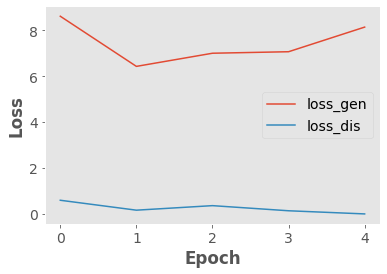

In [22]:
plt.plot(np.array(loss_gen_epoch), label='loss_gen')
plt.plot(np.array(loss_dis_epoch), label='loss_dis')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

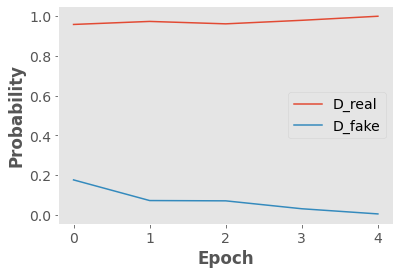

In [23]:
plt.plot(np.array(D_real_epoch), label='D_real')
plt.plot(np.array(D_fake_epoch), label='D_fake')
plt.xlabel("Epoch")
plt.ylabel("Probability")
plt.legend();

In [24]:
%%capture

fig = plt.figure(figsize=(10, 10))
ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list[::1]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('GAN.gif', writer='imagemagick', fps=2)

In [25]:
HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation

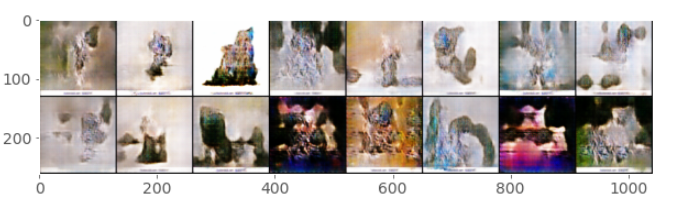